In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from nn.UNet import UNet
import torch as th
from torchvision import transforms
from skimage.measure import label, regionprops
import tifffile
from skimage.morphology import disk, binary_erosion, binary_dilation, binary_opening, binary_closing

In [ ]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
model = UNet(1, 1).to(device)
model.load_state_dict(th.load("/home/quantum/MScThesisCode/unet.th", weights_only=True))
model.eval()
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

NameError: name 'th' is not defined

In [ ]:
img = th.from_numpy(np.astype(tifffile.imread("/mnt/d/d1/AB-TGF/15_D6.tif")[-1,], np.float32)).unsqueeze(0).unsqueeze(0).to(device)
segm = model(img)

In [24]:
segm_a = (th.sigmoid(segm) > 0.5).long().detach().squeeze(0).squeeze(0).cpu().numpy()
segm_a = binary_erosion(segm_a, disk(3))
labeled_area = label(segm_a)
regions = regionprops(labeled_area)

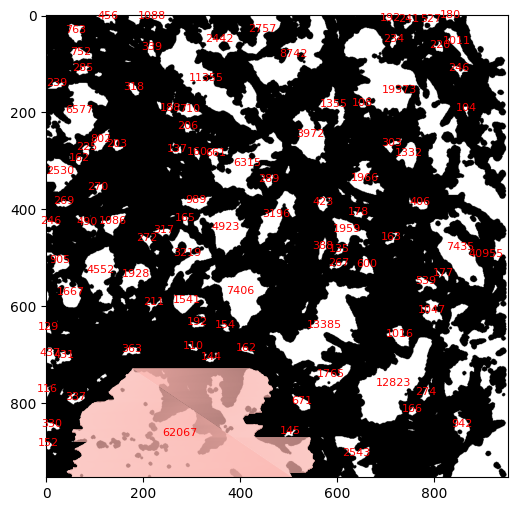

In [25]:
import matplotlib.cm as cm

# Assuming segm_a is already processed

# Find the top 10 largest holes
top_10_regions = sorted(regions, key=lambda r: r.area, reverse=True)[0:1]

# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(segm_a, cmap='gray')

# Generate pastel colors using matplotlib colormap (e.g., "Pastel1")
pastel_colors = cm.Pastel1(np.linspace(0, 1, len(top_10_regions)))

# Color the top 10 largest holes in pastel colors
for i, region in enumerate(top_10_regions):
    if region.area > 100:  # Ensure significant size
        coords = region.coords
        ax.fill(coords[:, 1], coords[:, 0], color=pastel_colors[i], alpha=0.7, label=f"Largest Hole {i+1}")

# Annotate all regions with areas
for region in regions:
    y, x = region.centroid
    if region.area > 100:
        ax.text(x, y, f"{region.area:.0f}", color="red", fontsize=8, ha="center")


plt.show()

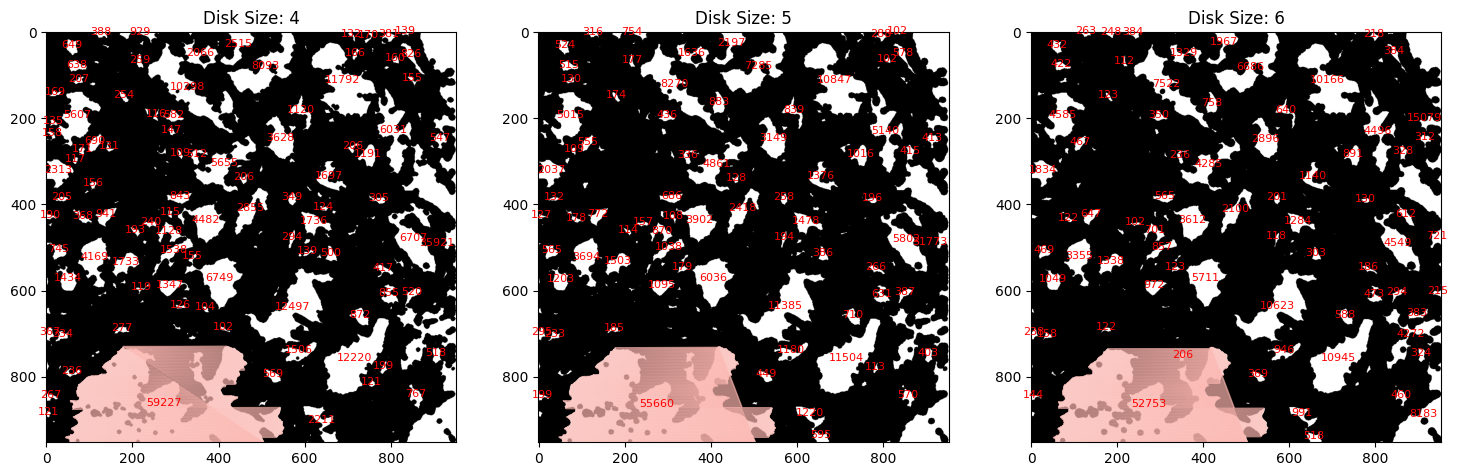

In [30]:
# Example usage
disk_sizes = [4,5,6]
fig, axes = plt.subplots(1, len(disk_sizes), figsize=(6 * len(disk_sizes), 6))
if len(disk_sizes) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, d_size in zip(axes, disk_sizes):
    segm_a = (th.sigmoid(segm) > 0.5).long().detach().squeeze(0).squeeze(0).cpu().numpy()
    segm_a = binary_erosion(segm_a, disk(d_size))
    labeled_area = label(segm_a)
    regions = regionprops(labeled_area)
    top_regions = sorted(regions, key=lambda r: r.area, reverse=True)[:1]
    
    # Display binary image
    ax.imshow(segm_a, cmap='gray')
    ax.set_title(f"Disk Size: {d_size}")
    
    # Generate pastel colors
    pastel_colors = cm.Pastel1(np.linspace(0, 1, len(top_regions)))
    
    # Color the largest holes
    for i, region in enumerate(top_regions):
        if region.area > 100:
            coords = region.coords
            ax.fill(coords[:, 1], coords[:, 0], color=pastel_colors[i], alpha=0.7, label=f"Largest Hole {i+1}")
    
    # Annotate regions
    for region in regions:
        y, x = region.centroid
        if region.area > 100:
            ax.text(x, y, f"{region.area:.0f}", color="red", fontsize=8, ha="center")
    
plt.show()